In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from scipy.io import loadmat
import numpy as np
from torch.nn.functional import mse_loss
from tqdm import tqdm

from models import PINN, ReconPINN, recon_field

In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [3]:
# Load in data
p_data = loadmat("./data/Re_100/pressure.mat")
v_data = loadmat("./data/Re_100/velocity.mat")
x_train = torch.tensor(p_data["x"][0], requires_grad=True).float().to(device)
y_train = torch.tensor(p_data["y"][0], requires_grad=True).float().to(device)
pos_train = torch.stack((x_train, y_train)).T

p_train = torch.tensor(p_data["p"][0], requires_grad=True).float().to(device)
u_train = torch.tensor(v_data["u"][0], requires_grad=True).float().to(device)
v_train = torch.tensor(v_data["v"][0], requires_grad=True).float().to(device)
sol_train = torch.stack((u_train, v_train, p_train)).T

In [4]:
recon_num_obs_list = [10, 20, 30, 40]
MSE_MODELS = [f"saved-models/recon-models/recon-fields-{x}-pts-mse-tol.model" for x in recon_num_obs_list]
MSE_MODELS_RECON = []
print("\nMSE MODELS:")
for mse_model in MSE_MODELS:
    recon_model = ReconPINN(in_dim=2, out_dim=3, data=(pos_train, sol_train), recon_num_obs=1, my_lr=0.1, depth=9, width=20)
    recon_model.to(device)
    recon_model.load_state_dict(torch.load(mse_model, map_location=torch.device('cpu')))
    MSE_MODELS_RECON.append(recon_field(recon_model))


MSE MODELS:
REL L2 ERRS: 0.194 0.121 0.489
REL L2 ERRS: 0.189 0.126 0.573
REL L2 ERRS: 0.158 0.125 0.552
REL L2 ERRS: 0.15 0.109 0.497


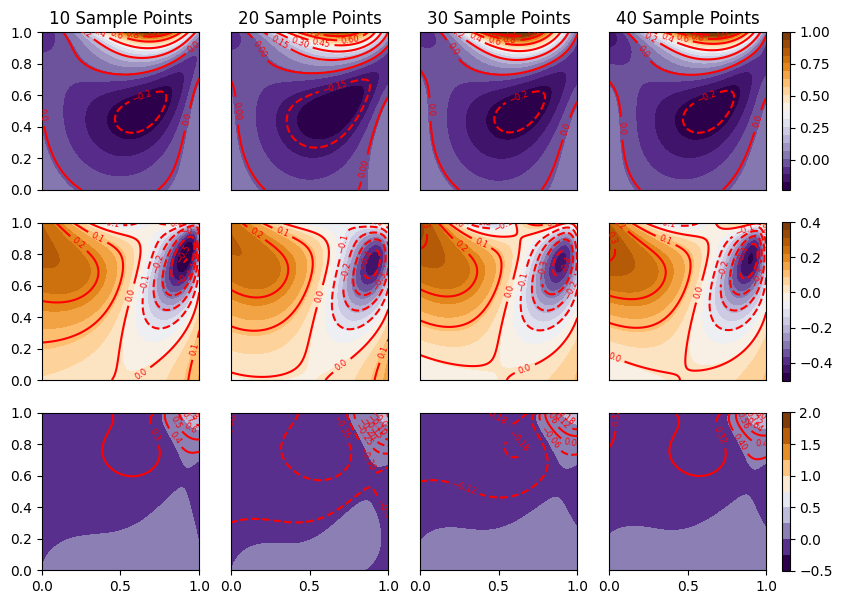

In [5]:
from matplotlib.colors import Normalize

fig, axs = plt.subplots(3,4,figsize=(10, 7))
cmap = plt.get_cmap('PuOr_r', 20)
cmap2= plt.get_cmap('PuOr_r', 10)

NUM_PTS = 3000

for i in range(len(recon_num_obs_list)):
    x,y,u,v,p = MSE_MODELS_RECON[i]
    extent = x.min(), x.max(), y.min(), y.max()
    u_im = axs[0,i].imshow(u, extent=extent, vmin=-0.24, vmax=1, origin='lower', cmap=cmap)
    
    v_im = axs[1,i].imshow(v, extent=extent, vmin=-0.5, vmax=0.4, origin='lower', cmap=cmap)
    p_im = axs[2,i].imshow(p-p[0,0], extent=extent, vmin=-0.5, vmax=2.0, origin='lower', cmap=cmap2)
    
    u_contours = axs[0,i].contour(x, y, u, levels=7, colors='red')
    v_contours = axs[1,i].contour(x,y,v,levels=7, colors='red')
    p_contours = axs[2,i].contour(x,y,p,levels=7, colors='red')
    plt.clabel(u_contours, inline=1, fontsize=6)
    plt.clabel(v_contours, inline=1, fontsize=6)
    plt.clabel(p_contours, inline=1, fontsize=6)
    
for i in range(3):
    for j in range(4):
        if j==0 and i!=2:
            axs[i,j].set_xticks([])
        elif j!=0 and i==2:
            axs[i,j].set_yticks([])
        elif i!=2 and j!=0:
            axs[i,j].set_xticks([])
            axs[i,j].set_yticks([])
            
        if i==0:
            axs[i,j].set_title(f"{recon_num_obs_list[j]} Sample Points")
            
                         
plt.colorbar(u_im, ax=axs[0], fraction=0.045, pad=0.02)
plt.colorbar(v_im, ax=axs[1],fraction=0.045, pad=0.02)
plt.colorbar(p_im, ax=axs[2], fraction=0.045, pad=0.02)
plt.savefig("figures/recon-fields-with-contour.png", bbox_inches='tight')

In [6]:
forward_model = PINN(in_dim=2, out_dim=3, data=(pos_train, sol_train), my_lr=0.005, depth=7, width=50, rff_dim=None, sigma=1)
forward_model.load_state_dict(torch.load("./saved-models/forward-depth-7-width-50-vanilla-finite-diff.model", map_location=torch.device('cpu')))
x,y,u,v,p = recon_field(forward_model)

REL L2 ERRS: 0.008 0.024 0.192


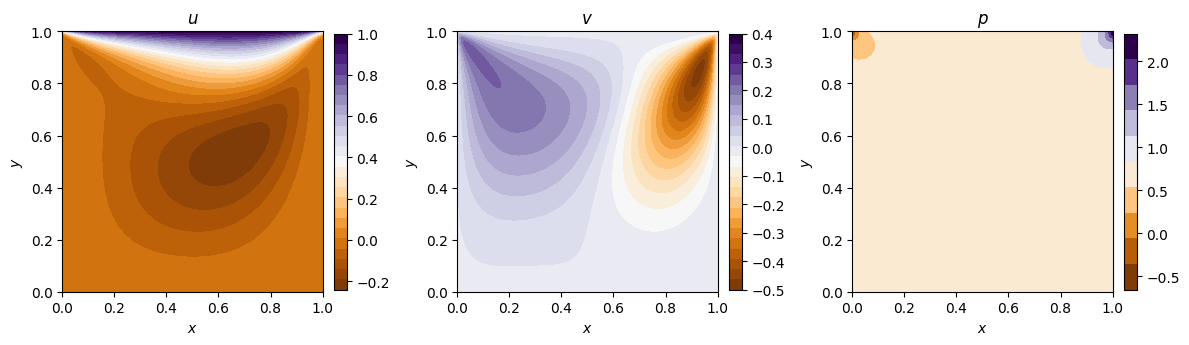

In [16]:
fig, axs = plt.subplots(1,3, figsize=(12, 5))
cmap = plt.get_cmap('PuOr', 25)
cmap2= plt.get_cmap('PuOr', 10)
extent = x.min(), x.max(), y.min(), y.max()
u_im = axs[0].imshow(u, vmin=-0.24, vmax=1, extent=extent, origin='lower', cmap=cmap)
v_im = axs[1].imshow(v, vmin=-0.5, vmax=0.4, extent=extent, origin='lower', cmap=cmap)
p_im = axs[2].imshow(p, origin='lower', extent=extent, cmap=cmap2)

for ax in axs:
    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")
                     
plt.colorbar(u_im, ax=axs[0], fraction=0.045, pad=0.04)
plt.colorbar(v_im, ax=axs[1],fraction=0.045, pad=0.04)
plt.colorbar(p_im, ax=axs[2], fraction=0.045, pad=0.04)
TITLES = ["$u$", "$v$", "$p$"]
for i in range(3):
    axs[i].set_title(TITLES[i])
plt.tight_layout()
plt.savefig("figures/forward-fields.png", bbox_inches='tight')

In [26]:
sol_hat = forward_model(x_train, y_train)

In [30]:
x_train

tensor([0.0000, 0.0100, 0.0200,  ..., 0.9750, 0.9850, 0.9950],
       grad_fn=<ToCopyBackward0>)

AttributeError: PathCollection.set() got an unexpected keyword argument 'marker_size'

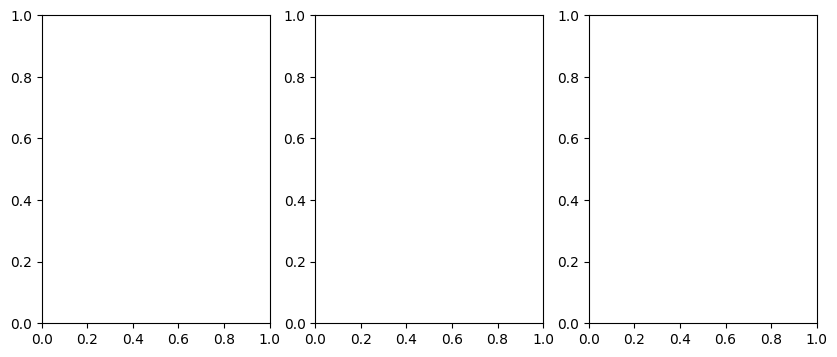

In [40]:
fig, axs = plt.subplots(1,3, figsize=(10,4))

axs[0].scatter(y_train.detach().numpy(), 
                 np.abs((sol_hat[:,0] - sol_train[:,0]).detach().numpy()), s=1)
axs[1].scatter(y_train.detach().numpy(), 
                 np.abs((sol_hat[:,1] - sol_train[:,1]).detach().numpy()), markersize=1)
axs[2].scatter(y_train.detach().numpy(), 
                 np.abs(((sol_hat[:,2] - sol_hat[0,2]) - sol_train[:,2]).detach().numpy()), markersize=1)

axs[0].set_title("$|\hat u - u$|")
axs[0].set_xlabel("$y$")

axs[1].set_title("$|\hat v - v$|")
axs[1].set_xlabel("$y$")

axs[2].set_title("$|\hat p - p$|")
axs[2].set_xlabel("$y$")
plt.savefig("figures/forward-spatial-err.png", bbox_inches='tight')
plt.tight_layout()

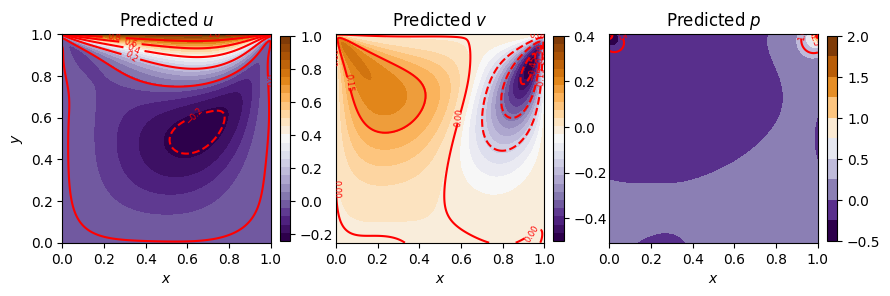

In [10]:
fig, axs = plt.subplots(1,3,figsize=(10, 7))
cmap = plt.get_cmap('PuOr_r', 25)
cmap2= plt.get_cmap('PuOr_r', 10)

extent = x.min(), x.max(), y.min(), y.max()
u_im = axs[0].imshow(u, extent=extent, vmin=-0.24, vmax=1, origin='lower', cmap=cmap)
v_im = axs[1].imshow(v, extent=extent, vmin=-0.5, vmax=0.4, origin='lower', cmap=cmap)
p_im = axs[2].imshow(p-p[0,0], extent=extent, vmin=-0.5, vmax=2.0, origin='lower', cmap=cmap2)
plt.colorbar(u_im, ax=axs[0], fraction=0.045, pad=0.04)
plt.colorbar(v_im, ax=axs[1],fraction=0.045, pad=0.04)
plt.colorbar(p_im, ax=axs[2], fraction=0.045, pad=0.04)

axs[0].set_title("Predicted $u$")
axs[1].set_title("Predicted $v$")
axs[2].set_title("Predicted $p$")

axs[1].set_yticks([])
axs[2].set_yticks([])

axs[0].set_ylabel("$y$")
for ax in axs:
    ax.set_xlabel("$x$")

u_contours = axs[0].contour(x, y, u, levels=6, colors='red')
v_contours = axs[1].contour(x,y,v,levels=6, colors='red')
p_contours = axs[2].contour(x,y,p,levels=6, colors='red')
plt.clabel(u_contours, inline=1, fontsize=6)
plt.clabel(v_contours, inline=1, fontsize=6)
plt.clabel(p_contours, inline=1, fontsize=6)

plt.savefig("figures/forward-fields-with-contours.png", bbox_inches='tight')

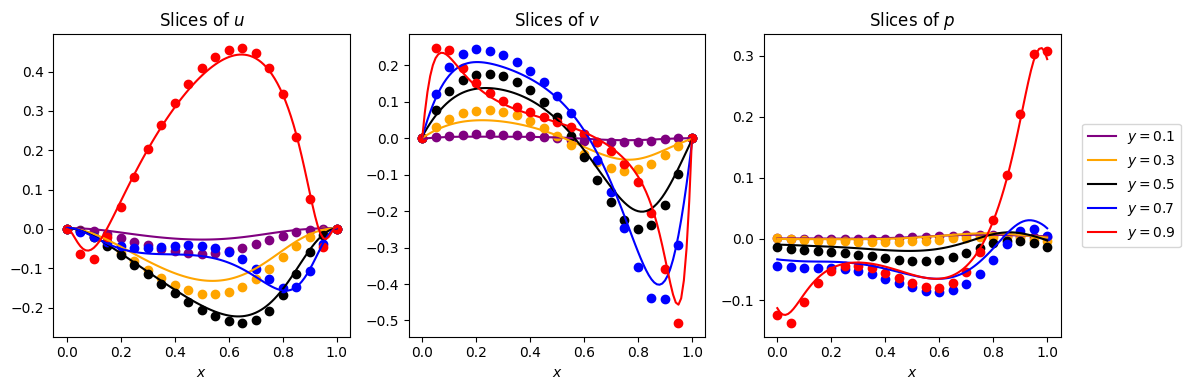

In [11]:
with torch.no_grad():
    y_vals = [0.1, 0.3, 0.5, 0.7, 0.9]
    fig, axs = plt.subplots(1,3, figsize=(12, 4))
    cs = ['purple', 'orange', 'black', 'blue', 'red']
    for i in range(len(y_vals)):
        y_val = y_vals[i]
        u_val = u_train[y_train == y_val].cpu().detach().numpy()
        v_val = v_train[y_train == y_val].cpu().detach().numpy()
        p_val = p_train[y_train == y_val].cpu().detach().numpy()
        x_val = x_train[y_train == y_val]
        axs[0].scatter(x_val.cpu().detach().numpy()[::5], u_val[::5], c=cs[i])
        axs[1].scatter(x_val.cpu().detach().numpy()[::5], v_val[::5], c=cs[i])
        axs[2].scatter(x_val.cpu().detach().numpy()[::5], p_val[::5], c=cs[i])
        
        sol_hat = forward_model(x_val.to(device), y_val*torch.ones_like(x_val)).cpu().detach().numpy()
        u_val_hat = sol_hat[:,0]
        v_val_hat = sol_hat[:,1]
        p_val_hat = sol_hat[:,2]
        axs[0].plot(x_val.cpu(), u_val_hat, c=cs[i], label=f"$y={y_val}$")
        axs[1].plot(x_val.cpu(), v_val_hat, c=cs[i], label=f"$y={y_val}$")
        axs[2].plot(x_val.cpu(), p_val_hat - p[0,0], c=cs[i], label=f"$y={y_val}$")

    plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))
    axs[0].set_xlabel("$x$")
    axs[1].set_xlabel("$x$")
    axs[2].set_xlabel("$x$")
    axs[0].set_title("Slices of $u$")
    axs[1].set_title("Slices of $v$")
    axs[2].set_title("Slices of $p$")
    plt.tight_layout()
    plt.savefig("forward-slices.png", bbox_inches='tight')

In [12]:
losses = torch.load("data/forward-train-losses.tensor", map_location=torch.device("cpu"))

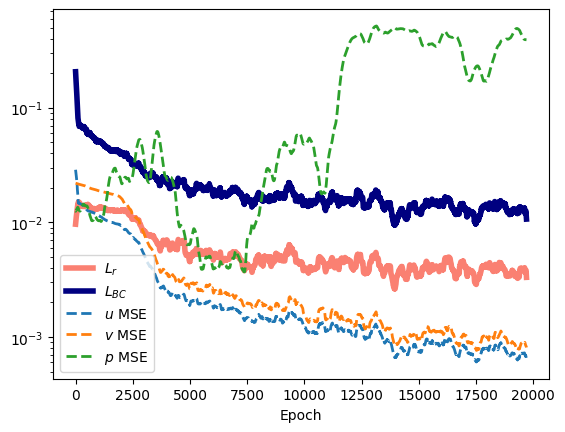

In [13]:
def moving_window_avg(x, window=300):
    x_avg = np.zeros(len(x) - window)
    for i in range(len(x) - window):
        x_avg[i] = np.mean(x[i:i+window])
    return x_avg

# plt.plot(losses[3:5000,0], c='salmon', alpha=0.3)
# plt.plot(losses[3:5000,1], c='navy', alpha=0.3)
plt.plot(moving_window_avg(losses[:,0].flatten()), c='salmon', linewidth=4, label='$L_r$')
plt.plot(moving_window_avg(losses[:,1].flatten()), c='navy', linewidth=4, label='$L_{BC}$')
# plt.plot(losses[:,0]+losses[:,1], label='Total Loss', alpha=0.6)
plt.plot(moving_window_avg(losses[:,2]), '--', linewidth=2, label='$u$ MSE')
plt.plot(moving_window_avg(losses[:,3]), '--', linewidth=2, label='$v$ MSE')
plt.plot(moving_window_avg(losses[:,4]), '--', linewidth=2, label='$p$ MSE')
plt.yscale("log")
plt.legend()
plt.xlabel("Epoch")
plt.savefig("figures/forward-training-losses.png",bbox_inches='tight')